# Web Scrapping Compiled Yearly US AQI Data
 - https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
 - https://aqs.epa.gov/aqsweb/airdata/download_files.html
 - https://aqs.epa.gov/aqsweb/documents/about_aqs_data.html
 - https://aqs.epa.gov/aqsweb/documents/data_api.html#variables
 
 

# Part 1 - Webs Scrape Download links

In [45]:
from io import BytesIO
from zipfile import ZipFile
import requests
from urllib.request import urlopen

# if error, No module named 'bs4', run --conda install beautifulsoup4-- in conda env
from bs4 import BeautifulSoup 

In [2]:
# link to EPA website page for daily AQI values
html_page = requests.get('https://aqs.epa.gov/aqsweb/airdata/download_files.html')
soup = BeautifulSoup(html_page.content, 'html.parser')

# find all a href links available on this page
file_urls = soup.findAll('a', href=lambda href: href and href.startswith("daily_aqi_by_county_"))
links = ['https://aqs.epa.gov/aqsweb/airdata/'+link.get('href') for link in file_urls]
print(links)

['https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2021.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2020.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2019.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2016.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2015.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2014.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2013.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2012.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2011.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2010.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2009.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2008.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2007.

## Download, Unzip, and Compile

In [ ]:
# initiating a dataframe
aqi_df = pd.DataFrame()

#forloop to download, unzip, and compile df
for link in links:
    
    # open url
    resp = urlopen(link)
    
    # read zipfile
    zipfile = ZipFile(BytesIO(resp.read()))
    
    # get the csv file name
    fname = zipfile.namelist()[0]
    
    # convert to pandas dateframe
    df = pd.read_csv(zipfile.open(fname), dtype=object)
    
    # close zipfile we don't need
    zipfile.close()
    
    # concatenate dataframes
    aqi_df = pd.concat([aqi_df, df], ignore_index=True, sort=False)
    
    # let me know how much it is completed.
    print(f'{fname} Completed')

## Export dataset
 - added to data folder which is in .gitignore

In [72]:
# aqi_df.to_csv('data/aqi_df.csv')

# Part 2 - New York City Air Quality Analysis during Covid 19

# Objective

#### For an analysis of air quality changes in New York City, we plan to look at the AQI data during the COVID-19 lockdowns during March and April of 2020. This will be compared to AQI data during the same months in years prior. 

Start Date: March 1, 2020
<br>
End Date: March 1, 2021

In [74]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

# Read in Dataset

In [87]:
# US daily AQI data from 1980-01-01 to 2021-05-18
aqi=pd.read_csv('data/aqi_df.csv', usecols={'State Name',
                                            'county Name',
                                            'Date',
                                            'AQI',
                                            'Category',
                                            'Defining Parameter',
                                            'Defining Site',
                                            'Number of Sites Reporting'})

# set columns to strings to keep leading zeros
dtype_dic= {'State Code':str,
            'County Code':str,
            'Site Number':str}
dtype = dtype_dic

# AQI monitor locations
monitors=pd.read_csv('data/aqs_monitors.csv', usecols ={'State Code',
                                                        'County Code',
                                                        'Site Number',
                                                        'Latitude',
                                                        'Longitude',
                                                        'Monitor Type'},
                    dtype=dtype_dic)

In [3]:
# data types of columns
print(monitors.dtypes)
print("")
print(aqi.dtypes)

State Code       object
County Code      object
Site Number      object
Latitude        float64
Longitude       float64
Monitor Type     object
dtype: object

State Name                   object
county Name                  object
Date                         object
AQI                           int64
Category                     object
Defining Parameter           object
Defining Site                object
Number of Sites Reporting     int64
dtype: object


In [91]:
# combine columns together to get site number
monitors['Defining Site']=(monitors['State Code']+'-'+
                           monitors['County Code']+'-'+
                           monitors['Site Number'])

In [85]:
monitors.head()

,State Code,County Code,Site Number,Latitude,Longitude,Monitor Type,Defining Site
0,01,001,0001,32.437458,-86.472891,OTHER,01-001-0001
1,01,001,0001,32.437458,-86.472891,OTHER,01-001-0001
2,01,001,0002,32.428470,-86.443585,SLAMS,01-001-0002
3,01,001,0002,32.428470,-86.443585,SLAMS,01-001-0002
4,01,001,0003,32.332659,-86.791521,OTHER,01-001-0003


In [88]:
aqi.head()

,State Name,county Name,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,DeKalb,2021-01-01,30,Good,Ozone,01-049-9991,1
1,Alabama,DeKalb,2021-01-02,27,Good,Ozone,01-049-9991,1
2,Alabama,DeKalb,2021-01-03,34,Good,Ozone,01-049-9991,1
3,Alabama,DeKalb,2021-01-04,36,Good,Ozone,01-049-9991,1
4,Alabama,DeKalb,2021-01-05,31,Good,Ozone,01-049-9991,1


## Filter for New York

In [203]:
# select specific states to compare
states = ['New York']
aqi_subset=aqi.loc[aqi['State Name'].isin(states)]

### Merge dataframes

In [204]:
# merge datasets
aqi_df = aqi_subset.merge(monitors, on='Defining Site', how='left').drop_duplicates("Date", ignore_index=True)

In [205]:
# format date as datetime
aqi_df['Date']=pd.to_datetime(aqi_df['Date'], format = '%Y-%m-%d')

In [206]:
# convert Category column to category data type
aqi_df['Category']=aqi_df.Category.astype('category')

### Create geodatafrome from Lat/Long

In [210]:
# convert to geodataframe
geoms=gpd.points_from_xy(aqi_df['Longitude'], aqi_df['Latitude'], crs='EPSG:4326')

aqi_df=gpd.GeoDataFrame(aqi_df,geometry=geoms)

In [211]:
aqi_df.tail()

,State Name,county Name,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,State Code,County Code,Site Number,Latitude,Longitude,Monitor Type,geometry
15062,New York,Broome,1980-02-19,55,Moderate,SO2,36-007-0007,1,36,007,0007,42.099798,-75.893250,SLAMS,POINT (-75.89325 42.09980)
15063,New York,Broome,1980-02-20,34,Good,Ozone,36-007-0007,1,36,007,0007,42.099798,-75.893250,SLAMS,POINT (-75.89325 42.09980)
15064,New York,Broome,1980-03-14,30,Good,Ozone,36-007-0007,1,36,007,0007,42.099798,-75.893250,SLAMS,POINT (-75.89325 42.09980)
15065,New York,Broome,1980-04-23,44,Good,Ozone,36-007-0007,1,36,007,0007,42.099798,-75.893250,SLAMS,POINT (-75.89325 42.09980)
15066,New York,Nassau,1980-02-29,13,Good,SO2,36-059-2003,5,36,059,2003,40.834822,-73.625683,OTHER,POINT (-73.62568 40.83482)


In [195]:
aqi_df.dtypes

State Name                           object
county Name                          object
Date                         datetime64[ns]
AQI                                   int64
Category                             object
Defining Parameter                   object
Defining Site                        object
Number of Sites Reporting             int64
State Code                           object
County Code                          object
Site Number                          object
Latitude                            float64
Longitude                           float64
Monitor Type                         object
geometry                           geometry
dtype: object

### Create simple dataframe of New York

In [212]:
aqi_ny = pd.DataFrame(aqi_df[['Date', 'AQI', 'Category', 'Defining Site','geometry']])

In [156]:
aqi_ny.dtypes

Date             datetime64[ns]
AQI                       int64
Category               category
Defining Site            object
geometry               geometry
dtype: object

In [163]:
color_type={'Good': 'green',
            "Moderate":'yellow',
            "Unhealthy for Sensitive Groups":'orange',
            "Unhealthy":'red',
            "Very Unhealthy":'purple',
            "Hazardous":'maroon'}

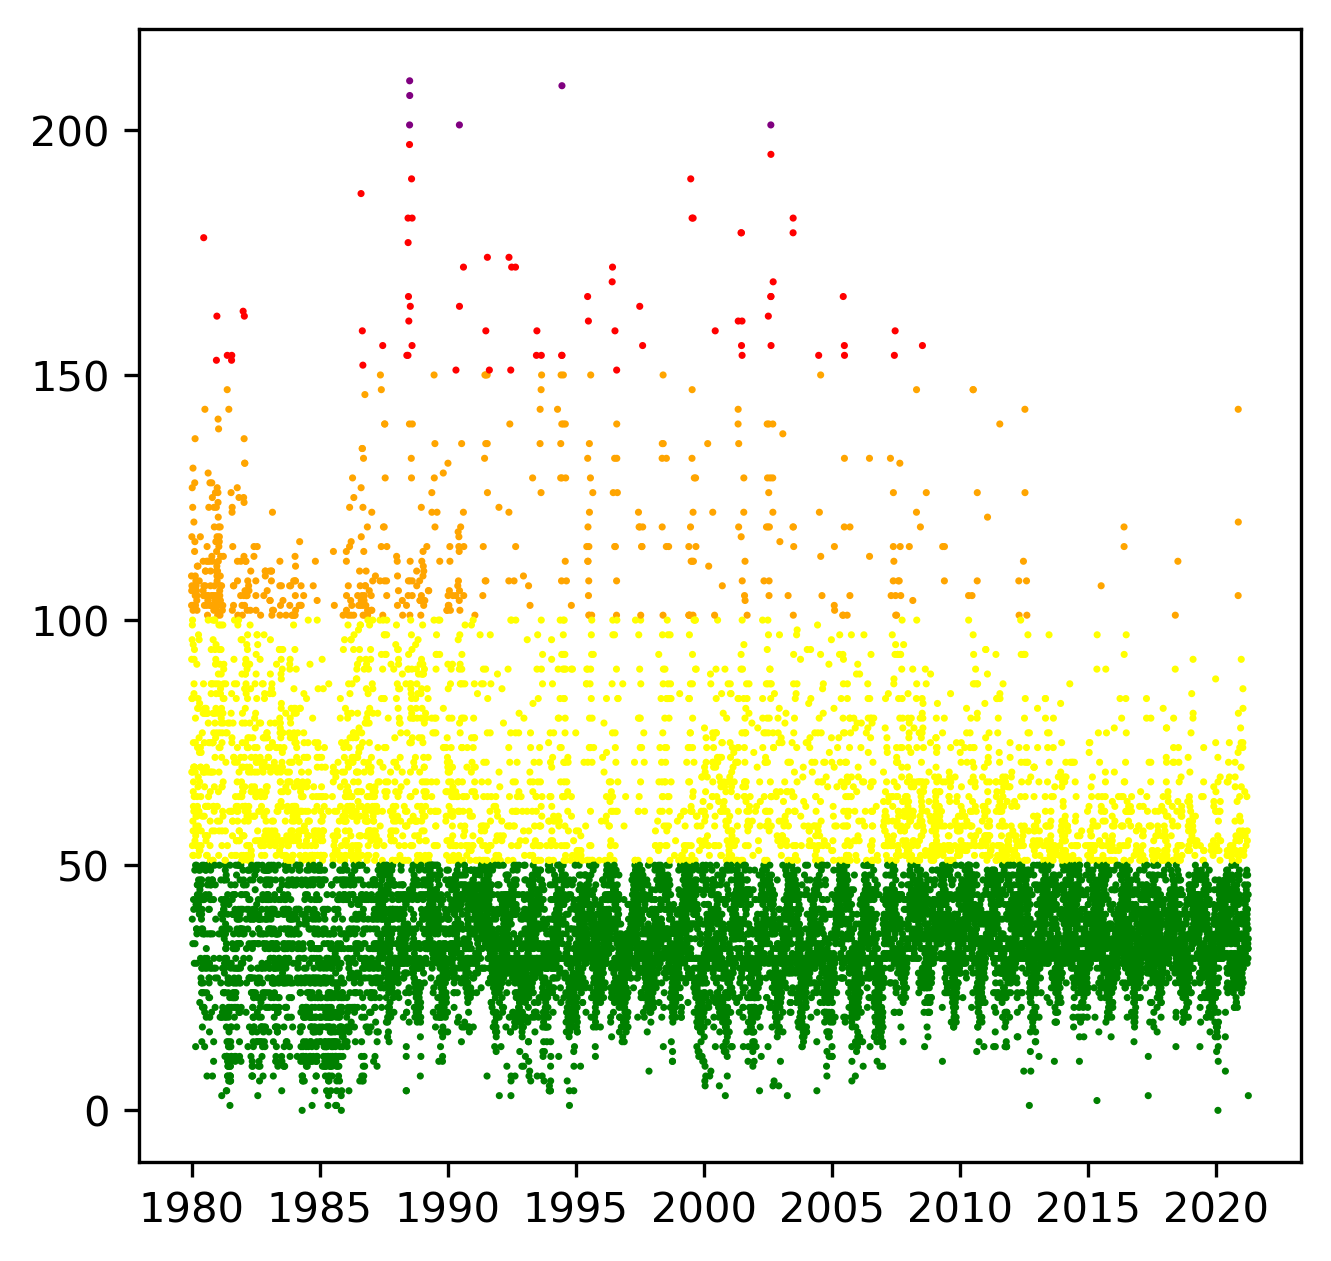

In [221]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
ax.scatter(aqi_ny['Date'], aqi_ny['AQI'], c=aqi_ny['Category'].apply(lambda x: color_type[x]), s=0.5)

In [178]:
aqi_ny

,Date,AQI,Category,Defining Site,geometry
0,2021-01-01,36,Good,36-001-0005,POINT (-73.75464 42.64225)
1,2021-01-02,28,Moderate,36-001-0012,POINT (-73.75733 42.68075)
2,2021-01-03,38,Unhealthy for Sensitive Groups,36-001-0005,POINT (-73.75464 42.64225)
3,2021-01-04,56,Unhealthy,36-001-0005,POINT (-73.75464 42.64225)
4,2021-01-05,39,Very Unhealthy,36-001-0005,POINT (-73.75464 42.64225)


(0.0, 400.0)

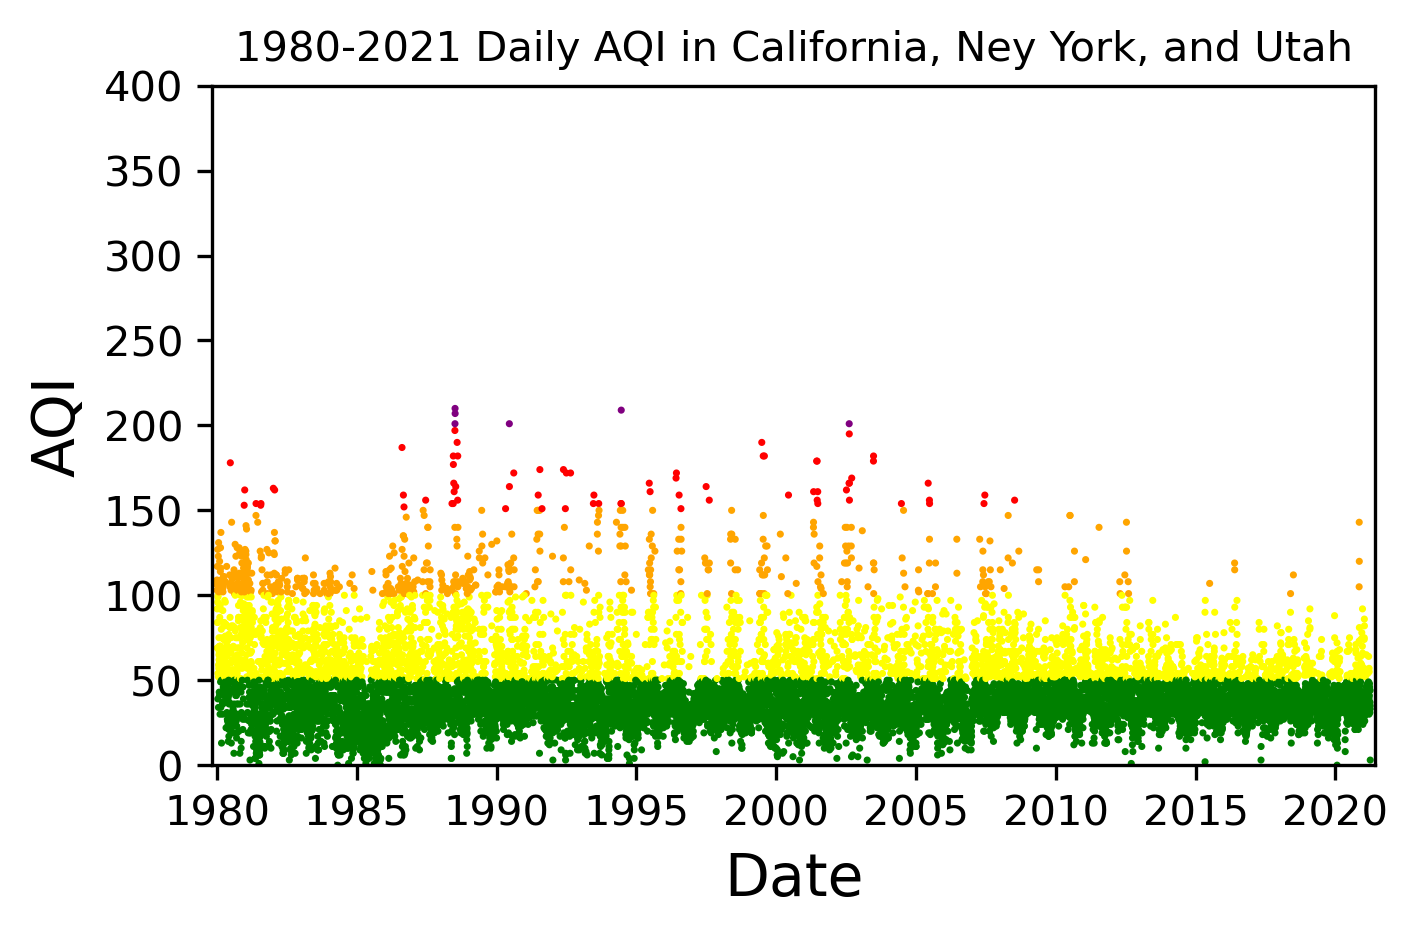

In [224]:

aqi_ny['AQI'].plot(ax=ax)


plt.figure(figsize=(5, 3), dpi=300)    # create a new figure, set size and resolution (dpi)
plt.scatter(aqi_ny['Date'], aqi_ny['AQI'], c=aqi_ny['Category'].apply(lambda x: color_type[x]), s=0.5)

#plt.legend(scatterpoints=1, handles='County Code', frameon=False, labelspacing=1, title='County Code')

plt.title('1980-2021 Daily AQI in California, Ney York, and Utah', fontsize=10)
plt.xlabel('Date', fontsize=14)
plt.ylabel('AQI', fontsize=14)
plt.xlim([np.datetime64('1979-11-01'), np.datetime64('2021-05-31')])
plt.ylim(0,400)